# Introduction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
import surprise

from sklearn import preprocessing
from sklearn.decomposition import NMF, TruncatedSVD, KernelPCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from surprise import AlgoBase
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split, RandomizedSearchCV, split

The main aim of the project is to present some applications of dimensionality reduction and optimization techniques to recommender systems. The dataset was downloaded from https://grouplens.org/datasets/movielens/ (ml-latest-small.zip) and it contains infomation about ratings of 600 users on 9000 movies. Let's start with a quick glance at the data:

In [23]:
ratings_path = os.path.join(os.getcwd(), os.path.join('ml-latest-small', 'ratings.csv'))
data = pd.read_csv(ratings_path).drop(["timestamp"], axis=1)
data.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Each row contains information about userId, movieId = id of the movie that was rated and rating itself. Event the first 5 rows of the data provide important insight: user 1 didn't rate some movies. This observation can be obviously extended to other users as we rather not expect that there is a person who rate all of the 9000 movies. What if we want to recommend a movie to user 1? Obviously we want to make the best possible recommendation, hence we are looking for movies that were not rated yet and match user 1 preferences. The simplest strategy assume that we have ratings of all the unrated movies and simply select movie with the highest rating. In order make recommendation we need to fill the gaps in ratings and this is the main role of recommender systems. 

# Exploratory data analysis

In some situations it will be easier to work with the data in Users $\times$ Movies format. This is so called utility matrix of recommendation system. There is one additionall step here. Algorithms of recommender system needs so called training data in order to properly recommend the items of interest. Training data contains ratings that we already know, but in the end we want recommendation for unrated movies. It turns out that trained algorithm work well for training data but it may not generalize well. Solution that is commonly used is based on splitting the data into training and test (unseen) set that will employed when evaluation of the sistem is carried. In this case train 10: test 1 ratio was proposed. 

In [28]:
def split_dataset(X, test_frac=0.1):
    test_set_size = int(X.shape[0]*test_frac)
    test_idx = np.random.choice(X.index, size=test_set_size, replace=False)
    test_set = X.loc[test_idx, :]
    train_set = X.copy()
    train_set.loc[test_idx, "rating"] = np.NaN
    return train_set, test_set.sort_values(by=["userId", "movieId"]), test_idx

X_train, X_test, test_idx = split_dataset(data)
util_matrix = X_train.pivot(index='userId', columns='movieId')

It was already mentioned that there are missing ratings, but the problem is more serious than it may be concluded from the introduction. In the next step we will look at the dataset as a matrix (an image) and color all missing ratings to dark shades and non missing to some colors.

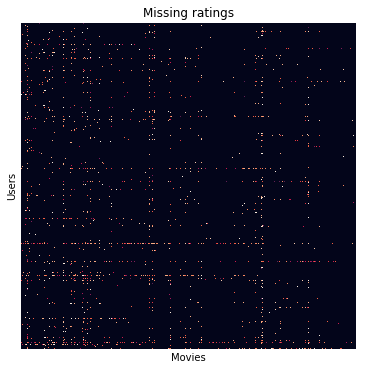

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

cmap = sns.color_palette("YlGnBu", len(data["rating"].unique()))
sns.heatmap(util_matrix.fillna(-1), 
            yticklabels=False, 
            xticklabels=False, 
            #cmap=cmap,
            cbar=False, 
            ax=ax)

ax.set_title('Visualisation of the missing ratings')
ax.set_xlabel('Movies')
ax.set_ylabel('Users');

Now it can be visually observed that the vast majority of votes are missing. Let's make it more more precise:

In [39]:
n_missing = np.sum(util_matrix.isna().values)
n_non_missing = util_matrix.size - n_missing
pd.Series([n_missing, n_non_missing, round(n_missing / util_matrix.size, 3)], index=['n. missing', 'n. non-missing', 'missing/all'])

n. missing        5840887.000
n. non-missing      90753.000
missing/all             0.985
dtype: float64

## Train test split

In [3]:
def split_dataset(X, test_frac=0.1):
    test_set_size = int(X.shape[0]*test_frac)
    test_idx = np.random.choice(X.index, size=test_set_size, replace=False)
    test_set = X.loc[test_idx, :]
    train_set = X.copy()
    train_set.loc[test_idx, "rating"] = np.NaN
    return train_set, test_set.sort_values(by=["userId", "movieId"]), test_idx

X_train, X_test, test_idx = split_dataset(data)
util_matrix = X_train.pivot(index='userId', columns='movieId')

## Data imputation

In [5]:
def adjust_to_mean(df, util_matrix, col):
    group_means = df.groupby(col).aggregate(np.mean)
    util_copy = util_matrix.copy()
    for col in util_copy.columns:
        util_copy.loc[:, col] = group_means.values
    return util_copy

user_avg_ratings = adjust_to_mean(X_train.drop('movieId', axis=1), util_matrix, 'userId')
movie_avg_ratings = adjust_to_mean(X_train.drop('userId', axis=1), util_matrix.T, 'movieId').T
grand_mean = data.loc[:, "rating"].mean()

mean_adjusted_ratings = user_avg_ratings + movie_avg_ratings - grand_mean
util_matrix_filled = util_matrix.mask(np.isnan, other=mean_adjusted_ratings)
util_matrix_filled = util_matrix_filled.mask(np.isnan, other=grand_mean)

### Dummy classifier

In [6]:
# mean_movie_rating = X_train["rating"].mean()
# dummy_prediction = np.full(X_test["rating"].shape, mean_movie_rating)
# dummy_rse = mean_squared_error(X_test["rating"], dummy_prediction)
# dummy_rse**(1/2)

### Mean adjusted classifier

In [7]:
def get_rse(prediction, test_set):
    ratings_comparison = prediction.merge(test_set, on=["userId", "movieId"]).loc[:, ["rating_x", "rating_y"]]
    error = mean_squared_error(ratings_comparison["rating_x"], 
                               ratings_comparison["rating_y"])
    return error ** (1/2)

In [8]:
# mean_adj_rse = get_rse(util_matrix_filled.stack().reset_index(), X_test)
# mean_adj_rse

### NMF

In [9]:
epsilon = 10e-4
nmf_offset = abs(np.min(util_matrix_filled.values)) + epsilon
nmf_model = NMF(init='random' , random_state=0)

rse_info = {}
# n_components <= min(132, 4841)
for n_components in range(10, 40, 5):
    nmf_model.n_components = n_components
    W = nmf_model.fit_transform(util_matrix_filled + nmf_offset)
    H = nmf_model.components_
    X_approx = np.dot(W,H) - nmf_offset
    X_approx = pd.DataFrame(X_approx, columns=util_matrix.columns, index=util_matrix.index)
    rse_info[n_components] = get_rse(X_approx.stack().reset_index(), X_test)

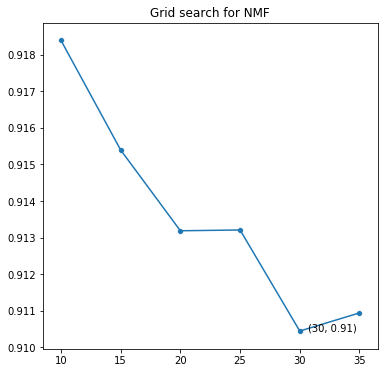

In [10]:
rse_series = pd.Series(rse_info)
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
sns.lineplot(data=pd.Series(rse_series), label="line", ax=ax)
sns.scatterplot(data=rse_series)

min_idx = rse_series.idxmin()
nmf_rse = rse_series.min()
ax.text(min_idx+.7, nmf_rse, str((min_idx, round(nmf_rse, 3))))

ax.legend_.remove()
ax.set_title('Grid search for NMF')
ax;

## SVD

In [11]:
svd = TruncatedSVD(random_state=42)

svd_dict = {}
for n_components in range(8, 30, 2):
    svd.n_components = n_components
    svd.fit(util_matrix_filled)
    sigma = np.diag(svd.singular_values_)
    VT = svd.components_
    W = svd.transform(util_matrix_filled)/svd.singular_values_
    H = np.dot(sigma ,VT)
    svd_prediction = W @ H
    svd_prediction = pd.DataFrame(svd_prediction, 
                                  columns=util_matrix_filled.columns, 
                                  index=util_matrix_filled.index)
    svd_dict[n_components] = [get_rse(svd_prediction.stack(), X_test), 
                              svd.explained_variance_ratio_.sum()]

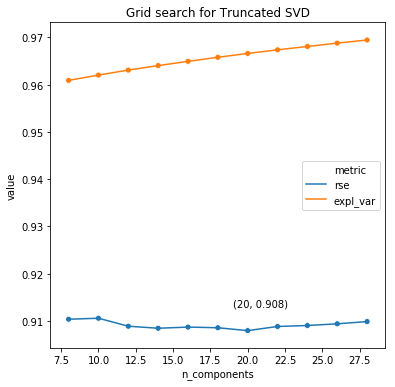

In [12]:
svd_df = pd.DataFrame.from_dict(svd_dict)
min_idx = svd_df.loc[0, :].idxmin()
svd_rse = svd_df.loc[0, :].min()

svd_df["value"] = ["rse", "expl_var"]
svd_df.set_index("value", inplace=True)
svd_df = svd_df.T.stack().reset_index()
svd_df.columns = ["n_components", "metric", "value"]

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
sns.lineplot(x="n_components", y="value", hue="metric", data=svd_df, ax=ax)
sns.scatterplot(x="n_components", y="value", hue="metric", data=svd_df, ax=ax, legend=False)

ax.text(min_idx-1, svd_rse+0.005, str((min_idx, round(svd_rse, 3))))
ax.set_title('Grid search for Truncated SVD');

## Kernel PCA

In [13]:
kpca = KernelPCA(fit_inverse_transform=True, gamma=10)
kpca_dict = {}
for kernel in ["rbf", "poly"]:
    kpca.kernel = kernel
    kpca_prediction = kpca.fit_transform(util_matrix_filled - grand_mean)
    kpca_prediction = kpca.inverse_transform(kpca_prediction)  + grand_mean
    kpca_prediction = pd.DataFrame(kpca_prediction, 
                                   columns=util_matrix_filled.columns, 
                                   index=util_matrix_filled.index)
    kpca_dict[kernel] = get_rse(kpca_prediction.stack(), X_test)


In [14]:
kpca_dict

{'poly': 0.9232410001016961, 'rbf': 0.9042700635861378}

## Surprise

### Dummy classifier with surpsise

In [15]:
reader = Reader()
data_surp = Dataset.load_from_df(data, reader)

In [16]:
class DummyRecommender(AlgoBase):

    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        self.global_mean = trainset.global_mean
        return self

    def estimate(self, u, i):
        return self.global_mean
    
cv = split.ShuffleSplit(n_splits=3, test_size=0.1, shuffle=True)
dummy_cv = cross_validate(DummyRecommender(), data_surp, verbose=True, cv=cv)
dummy_rse = dummy_cv['test_rmse'].mean()

Evaluating RMSE, MAE of algorithm DummyRecommender on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0400  1.0348  1.0434  1.0394  0.0036  
MAE (testset)     0.8250  0.8201  0.8257  0.8236  0.0025  
Fit time          0.03    0.04    0.05    0.04    0.01    
Test time         0.03    0.03    0.03    0.03    0.00    


In [17]:
def adjust_to_mean(df, util_matrix, col):
    group_means = df.groupby(col).aggregate(np.mean)
    util_copy = util_matrix.copy()
    for col in util_copy.columns:
        util_copy.loc[:, col] = group_means.values.reshape(-1)
    return util_copy

class MeanAdjustedRecommender(AlgoBase):

    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        self.global_mean = trainset.global_mean
        
        dataset = np.array([[uid, iid, r] for (uid, iid, r) in trainset.all_ratings()]).reshape((-1, 3))
        dataset = pd.DataFrame(dataset, columns=['userId', 'movieId', 'rating'])
        dataset = dataset.astype({'userId': 'int32', 'movieId':'int32'})
        
        util_matrix = dataset.pivot(index='userId', columns='movieId')
        user_avg_ratings = adjust_to_mean(dataset.drop('movieId', axis=1), util_matrix, 'userId')
        movie_avg_ratings = adjust_to_mean(dataset.drop('userId', axis=1), util_matrix.T, 'movieId').T
        self.mean_adj_matrix =  user_avg_ratings + movie_avg_ratings - self.global_mean
        
        return self

    def estimate(self, u, i):
        if self.trainset.knows_user(u) and self.trainset.knows_item(i):
            return self.mean_adj_matrix.iloc[u, i]
        return self.global_mean
    
mean_adj_cv = cross_validate(MeanAdjustedRecommender(), data_surp, verbose=True, cv=cv)
mean_adj_rse = mean_adj_cv['test_rmse'].mean()

Evaluating RMSE, MAE of algorithm MeanAdjustedRecommender on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9143  0.9205  0.9258  0.9202  0.0047  
MAE (testset)     0.6982  0.6957  0.7065  0.7001  0.0046  
Fit time          6.43    6.50    6.64    6.53    0.09    
Test time         0.60    0.61    0.62    0.61    0.01    


### SGD-Based SVD

In [18]:
# lr_all – The learning rate for all parameters. Default is 0.005.
# reg_all – The regularization term for all parameters. Default is 0.02
param_grid = {'n_epochs': [5, 10, 20, 30], 
              'lr_all': [0.007, 0.009, 0.01],
              'reg_all': [0.05, 0.1, 0.2, 0.4]}

gs =  RandomizedSearchCV(SVD, 
                         param_grid, 
                         measures=['rmse'], 
                         cv=cv,
                         return_train_measures=True,
                         refit=True,
                         n_iter=15, 
                         n_jobs=3)
gs.fit(data_surp)
svd_sgd = gs.best_estimator
svd_sgd_cv = cross_validate(svd_sgd['rmse'], data_surp, verbose=True, cv=cv)

#print(gs.best_params['rmse'])
#0.8541955377814917
#{'n_epochs': 20, 'lr_all': 0.009, 'reg_all': 0.05}

svd_sgd_rse = svd_sgd_cv['test_rmse'].mean()

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8495  0.8418  0.8677  0.8530  0.0109  
MAE (testset)     0.6508  0.6447  0.6596  0.6517  0.0061  
Fit time          6.95    7.20    7.34    7.16    0.16    
Test time         0.07    0.07    0.07    0.07    0.00    


## Models comparison

In [21]:
comparison = {"Dummy": dummy_rse, 
              "Mean Adj": mean_adj_rse,  
              "NMF": nmf_rse, 
              "Poly PCA": kpca_dict['poly'],
              "Rbf PCA": kpca_dict['rbf'],
              "SVD": svd_rse,
              "SVD + SGD": svd_sgd_rse}
pd.Series(comparison).round(5)

Dummy        1.03940
Mean Adj     0.92021
NMF          0.91045
Poly PCA     0.92324
Rbf PCA      0.90427
SVD          0.90795
SVD + SGD    0.85298
dtype: float64